이번에는 사전 학습된 ResNet-18과 후크(Hook)를 활용할 것이다.  
후크는 특정 이벤트가 발생했을 때 다른 코드를 실행하는 기술이다.  
Grad-CAM은 마지막 CL의 순전파와 역전파를 활용하므로 해당 레이어가 실행될 때 이벤트를 실행시켜 기울기 값을 받아온다.  
<br>
아래 코드는 후크 등록 과정이다.

In [1]:
import torch


class GradCAM:
    def __init__(self, model, main, sub):
        self.model = model.eval()
        self.register_hook(main, sub)

    def register_hook(self, main, sub):
        for name, module in self.model.named_children():
            if name == main:
                for sub_name, sub_module in module[-1].named_children():
                    if sub_name == sub:
                        sub_module.register_forward_hook(self.forward_hook)
                        sub_module.register_full_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.feature_map = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradient = grad_output[0]

    def __call__(self, x):
        output = self.model(x)

        index = output.argmax(axis=1)
        one_hot = torch.zeros_like(output)
        for i in range(output.size(0)):
            one_hot[i][index[i]] = 1

        self.model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)

        a_k = torch.mean(self.gradient, dim=(2, 3), keepdim=True)
        grad_cam = torch.sum(a_k * self.feature_map, dim=1)
        grad_cam = torch.relu(grad_cam)
        return grad_cam

이제 Grade-CAM을 생성한다.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 61.7MB/s]


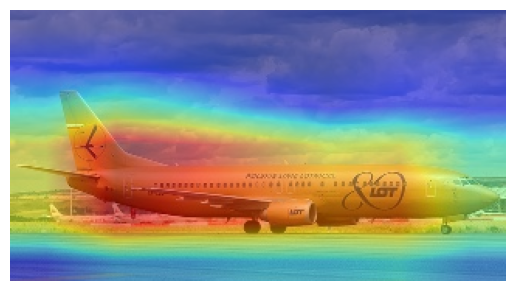

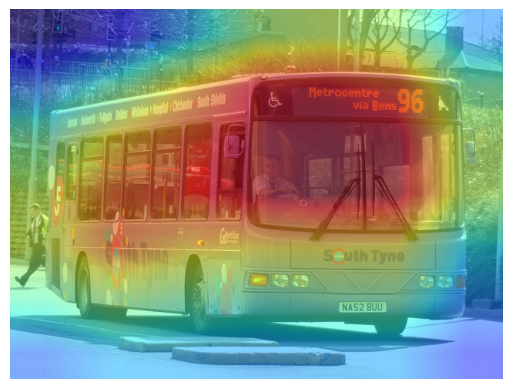

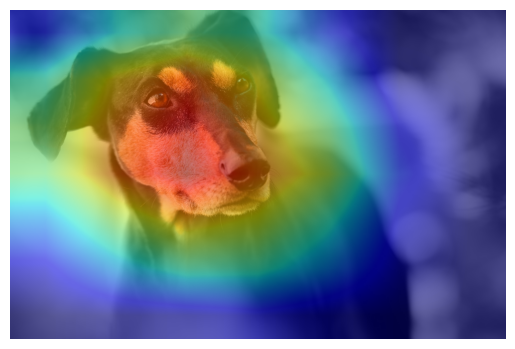

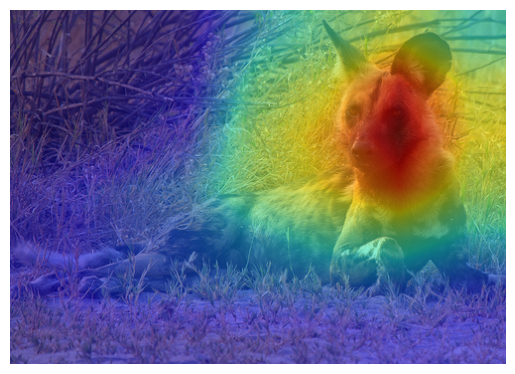

In [2]:
from PIL import Image
from torch.nn import functional as F
from torchvision import models
from torchvision import transforms
from matplotlib import pyplot as plt


transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]
)

files = [
    "/content/airplane.jpg", "/content/bus.jpg",
    "/content/dog.jpg", "/content/african_hunting_dog.jpg"
]
images, tensors = [], []
for file in files:
    image = Image.open(file)
    images.append(image)
    tensors.append(transform(image))
tensors = torch.stack(tensors)

model = GradCAM(
    model=models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1"),
    main="layer4",
    sub="conv2"
)
grad_cams = model(tensors)

for idx, image in enumerate(images):
    grad_cam = F.interpolate(
        input=grad_cams[idx].unsqueeze(0).unsqueeze(0),
        size=(image.size[1], image.size[0]),
        mode="bilinear",
    ).squeeze().detach().numpy()

    plt.imshow(image)
    plt.imshow(grad_cam, cmap="jet", alpha=0.5)
    plt.axis("off")
    plt.show()